In [6]:
%matplotlib notebook


# Standard library imports
import logging

# Third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation


# Local application imports
from myorbit.graphics_util import OrbitsPlot, calc_orbits_datav3, calc_interval
import myorbit.data_catalog as dc
from myorbit.two_body import calc_eph_planet
from myorbit.ephemeris_input import EphemrisInput
from myorbit.pert_cowels import calc_eph_by_cowells
from myorbit.util.constants import TWOPI, GM, GM_by_planet


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
eph = EphemrisInput(from_date="2009.01.01.0",
                       to_date = "2010.12.01.0",
                       step_dd_hh_hhh = "5 00.0",
                       equinox_name = "J2000")

#PLANETS = ['Earth','Mercury','Venus','Mars']
#PLANETS = ['Jupiter','Saturn','Uranus','Neptune', 'Pluto']
PLANETS = ['Earth','Mars']
#PLANETS = []
#PLANETS = ['Jupiter','Saturn']
#MINOR_BODYS = []
#MINOR_BODYS = ['Ceres','Pallas','Juno','Vesta']
#MINOR_BODYS = ['Ceres',APOFIS]
#MINOR_BODYS = ['Ceres']
MINOR_BODYS = []
#MINOR_BODYS=['2002 NN4','2010 NY65', dc.B_2013_XA22]
#COMETS = ['1P/Halley','2P/Encke','10P/Tempel 2','C/1995 O1 (Hale-Bopp)']
#COMETS = ['C/2019 Q4 (Borisov)']
#COMETS = ['D/1993 F2-A (Shoemaker-Levy 9)']
#COMETS = ['C/1988 L1 (Shoemaker-Holt-Rodriquez)'] #, 'C/1980 E1 (Bowell)','C/2019 Q4 (Borisov)']
#COMETS = ['C/2019 Q4 (Borisov)']
COMETS = []

orbs,  date_refs = calc_orbits_data(eph, PLANETS, MINOR_BODYS, COMETS)

Calculating data for  Earth
Calculating data for  Mars


In [16]:
def calc_tp(M_at_epoch, a, epoch_mjd):
    deltaT = TWOPI*a*np.sqrt(a/GM)*(1-M_at_epoch/TWOPI)
    return deltaT + epoch_mjd

In [3]:
df = dc.DF_COMETS
df = df.copy()

In [15]:
obj1= dc.read_body_elms_for("Ceres", dc.DF_BODIES) 
print (obj1)

Elements for Ceres
            epoch: 2020.5.31.0
     equinox name: J2000
                a: 2.7676569 AU
                e: 0.07755702
                i: 10.58862 dg
             Node: 80.28699 dg
                w: 73.73167 dg
                M: 162.68625170000004 dg
        epoch mjd: 59000.0 day
            T eq0: 0.0
    Period (days): 1681.7707812877022


In [17]:
# Calculation tp perihelion
calc_tp(obj1.M0,obj1.a,obj1.epoch_mjd )

59921.76804621471

In [5]:
eph = EphemrisInput.from_mjds(obj1.tp_mjd-150, obj1.tp_mjd+150, "5 00.0", "J2000" )
print(eph)

     Equinox name: J2000
            T eq0: 0.0
        From date: 1985/09/08
          To date: 1986/07/05
         From MJD: 46316.89532000013
           To MJD: 46616.89532000013
      Step (days): 5.0


In [32]:
PLANET_NAMES= [x.lower() for x in GM_by_planet.keys()]
def calc_interval(obj_names):
    tps=[]
    for name in obj_names:
        if name.lower() in PLANET_NAMES:
            print (f'{name} is a planet')
            continue
        obj = dc.read_comet_elms_for(name,dc.DF_COMETS)        
        if obj is not None:
            tps.append(obj.tp_mjd)
        else :
            obj = dc.read_body_elms_for(name,dc.DF_BODIES)
            if obj is not None:
                tp_mjd = calc_tp(obj.M0,obj.a,obj.epoch_mjd)
                tps.append(tp_mjd)
            else:
                print (f'Object {name} not found')
    if len(tps) > 0:
        return min(tps), max(tps)


In [39]:
OBJS=['Ceres','Pallas','Juno','Vesta']
tp_min, tp_max = calc_interval(OBJS)

The object Ceres does not exist in the Comets database
The object Pallas does not exist in the Comets database
The object Juno does not exist in the Comets database
The object Vesta does not exist in the Comets database


In [40]:
eph = EphemrisInput.from_mjds(tp_min-150, tp_max+150, "5 00.0", "J2000" )
print(eph)

     Equinox name: J2000
            T eq0: 0.0
        From date: 2021/07/27
          To date: 2023/08/31
         From MJD: 59422.49234204102
           To MJD: 60187.30596733968
      Step (days): 5.0


In [5]:
orbs, dfs, date_refs = calc_orbits_datav3 (eph, OBJS)

NameError: name 'calc_orbits_datav3' is not defined

In [3]:
def calc_orbits_data(eph):
    """
    Computes the orbits of the planets, minor bodys and comets 
    
    Args:
        eph : EphemerisData
        planets : List of name of planets
        minor_bodys : List of names of minor bodys or orbital elements itself
        comets : List of names of comets bodys or orbital elements itself

    Returns :
        orbs : A dictionary where the key is the name of the body and value is a
               matrix of n,3 (n rows per 3 cols) with the heliocentric coordinates h_x, h_y, h_z
               and the index is the date of corresponding to the position.
        date_refs :  list of the dates where the heliocentric coordinates were calculated
        
    """    
    orbs = {}
    dfs = []
    for name in obj_names:
        if name.lower() in PLANET_NAMES:
            df = calc_eph_planet(name, eph)
            orbs[name] = df
            dfs.append(df)
        else :
            df  = calc_eph_by_cowells(obj,eph, include_osc=False)
            orbs[name] = df
            dfs.append(df)
            
    date_refs = orbs[first(orbs.keys())]['date'].to_list()
    cols=['h_x','h_y','h_z']    
    for k, df in orbs.items():
        orbs[k] = df[cols].to_numpy()     
    return orbs, date_refs


In [7]:
# We generate another orbs object with geocentric positions (orbs_earth)
min_rows = 2147483648
for body_name in orbs.keys():
    min_rows = min(min_rows, orbs[body_name].shape[0])
for body_name in orbs.keys():
    mtx = orbs[body_name]
    orbs[body_name] = mtx[:min_rows,:]
orbs_earth = dict()
for body_name in filter(lambda x : x!='Earth', orbs.keys()):
    orbs_earth[body_name] = orbs[body_name] - orbs['Earth']    

In [8]:
# We calculate a dataframe with the distances to earth for these objects.
df = pd.DataFrame.from_dict({k:np.linalg.norm(v,axis=1) for (k,v) in orbs_earth.items()})
df['date_ref'] = date_refs
df = df.set_index('date_ref')
# The minimun distance is calculated for each body
df.idxmin(axis = 0)


Mars    2010/01/26
dtype: object

In [9]:
print ("Minimun distance ")
for col in df.columns:
    print (f"{col}: {min(df[col]):0.3f} AUs      {int(min(df[col])*1.496e+8)} Kms")


Minimun distance 
Mars: 0.664 AUs      99385449 Kms


### Show 3D

In [16]:
for orbs_plot.animate(3)

SyntaxError: invalid syntax (1747428835.py, line 1)

<IPython.core.display.Javascript object>


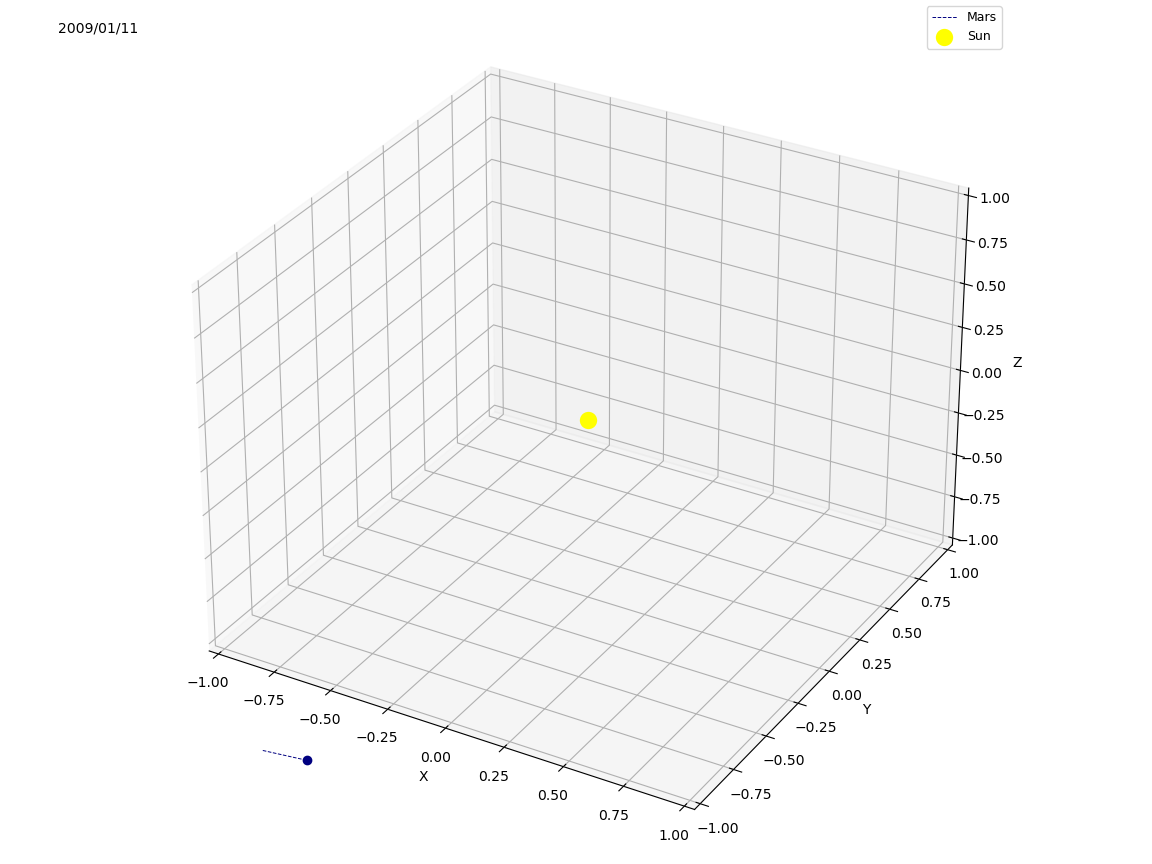

In [13]:
# normal size 6.4 x 4.8
fig = plt.figure(figsize=(11.52,8.64))
LIMITS=(-1,1)
# We need to choose if orbs or orbs_earth is shown
orbs_plot = OrbitsPlot(orbs_earth, date_refs, fig, LIMITS)
anim = animation.FuncAnimation(fig, orbs_plot.animate, init_func=orbs_plot.init, frames=len(date_refs), interval=1000, blit=False, repeat=False)
plt.show()


<IPython.core.display.Javascript object>


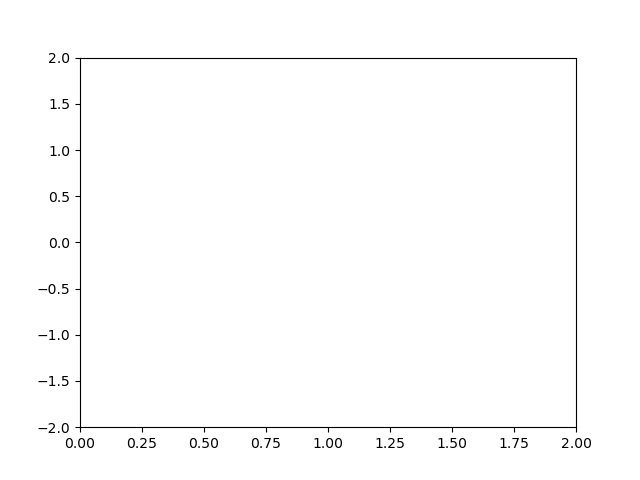

In [17]:
"""
Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
#anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

<IPython.core.display.Javascript object>


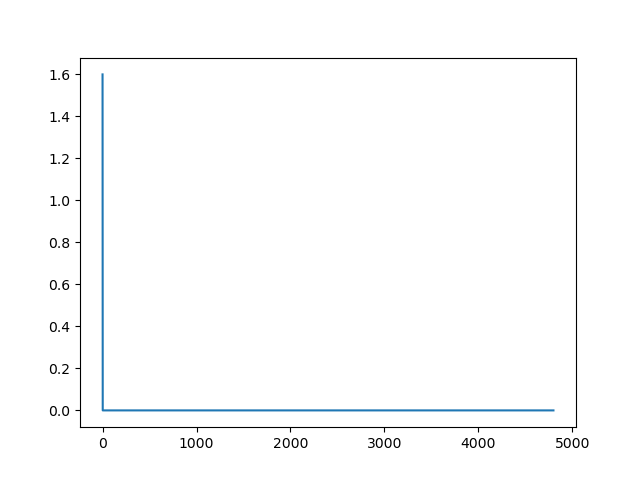

In [18]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation



class MyAni(object):
    def __init__(self, size=4800, peak=1.6):
        self.size = size
        self.peak = peak
        self.fig = plt.figure()
        self.x = np.arange(self.size)
        self.y = np.zeros(self.size)
        self.y[0] = self.peak
        self.line, = self.fig.add_subplot(111).plot(self.x, self.y)

    def animate(self, i):
        self.y[i - 1] = 0
        self.y[i] = self.peak
        self.line.set_data(self.x, self.y)
        return self.line,

    def start(self):
        self.anim = animation.FuncAnimation(self.fig, self.animate,
            frames=self.size, interval=20, blit=False)

if __name__ == '__main__':
    ani = MyAni()
    ani.start()

    plt.show()